# Лабораторная работа №4

Борисов Дмитрий Сергеевич (Вар. 5)
# Задание

Найти наиболее информативные признаки для данных вашего варианта. Произвести оценки зависимости точности модели и числа выбранных признаков. Используйте полученные ранее знания, такие как разбиение наборов данных и кросс-валидация.


## Результаты, которые необходимо получить в итоге:

1. DataFrame с признаками и их информативностью, отсортированный по убыванию.
2. Графики, показывающие результат оценки зависимости точности модели и числа выбранных признаков.
3. Таблица содержащая f1-score, precision, и recall полученные для лучшей модели, которую вы смогли обучить.
4. Визуализируйте предсказания вашей лучшей модели.

## Получение данных

In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler

In [3]:
data = np.load('5.npy')
mask = np.load('5_mask.npy')

In [4]:
data.shape, mask.shape

((512, 512, 237), (512, 512))

## Разбиение данных на тренировочные и тестовые

In [5]:
height = data.shape[0]
width = data.shape[1]
ordered_positions = np.array(np.meshgrid(np.arange(height), np.arange(width))).T.reshape(-1, 2)

In [6]:
train_indices, test_indices = train_test_split(ordered_positions, train_size=0.05, shuffle=True, random_state=0)

In [7]:
x_train = []
y_train = []
x_test = []
y_test = []

In [8]:
for idx in train_indices:
    x_train.append(data[idx[0], idx[1], ::])
    y_train.append(mask[idx[0], idx[1]])    
    
for idx in test_indices:
    x_test.append(data[idx[0], idx[1], ::])
    y_test.append(mask[idx[0], idx[1]])    
    
x_train = np.array(x_train, copy=False)
y_train = np.array(y_train, copy=False)
x_test = np.array(x_test, copy=False)
y_test = np.array(y_test, copy=False)

In [9]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [10]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((13107, 237), (13107,), (249037, 237), (249037,))

## Создание общего набора данных (соединение тренировочных и тестовых данных)

Необходимо для кросс-валидации

In [11]:
X = pd.DataFrame(np.vstack((x_train, x_test)))
Y = pd.DataFrame(np.hstack((y_train, y_test)))

In [12]:
X.shape, Y.shape

((262144, 237), (262144, 1))

## Создание рейтинга информативности признаков датасета

In [13]:
number_of_features = x_train.shape[1]   # 237

In [14]:
best_features = SelectKBest(score_func=chi2, k=50)

In [15]:
fit = best_features.fit(x_train, y_train)

In [16]:
# Create DataFrame from given data with given columns and indeces
best_features = pd.DataFrame(data={'feature': range(number_of_features), 'chi2_score': fit.scores_}, index=None)

Получение первых 10 самых информативных признаков

In [17]:
# Sort rows by the absolute value
best_features = best_features.sort_values(by='chi2_score', ascending=False)
best_features.iloc[:10]

,feature,chi2_score
142,142,186.517220
143,143,186.199404
141,141,185.519273
134,134,180.304297
136,136,178.768709
135,135,178.175016
140,140,178.021216
137,137,177.837384
149,149,176.869022
133,133,175.449762


Визуализация рейтинга признаков

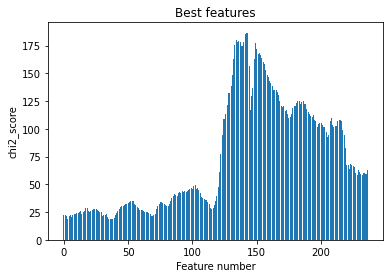

In [18]:
plt.bar(best_features['feature'], best_features['chi2_score'])
plt.title('Best features')
plt.xlabel('Feature number')
plt.ylabel('chi2_score')
plt.show()

## Выбор оптимального количества лучших признаков

Изначально планировалось использовать кросс-валидацию, но даже для данных лишь с несколькими признаками это занимало очень много времени.

Даже без кросс-валидации обычное обучение с кол-вом признаков от 10 до 50 занимает продолжительное время. Не исключается, что при более 50-ти лучших признаках точность классификации будет лучше.

In [19]:
# cv = 3
scores = []
for n_f in range(10, 50):
  cls = MLPClassifier(max_iter=500)
  features = best_features['feature'].iloc[:n_f].to_numpy()
  # score = cross_val_score(cls, X[features], Y[0], cv=cv, scoring='accuracy')
  cls.fit(x_train[:, features], y_train)
  score = cls.score(x_test[:, features], y_test)
  scores.append([n_f, score])
  # print(f"n_f = {n_f}\tscore = {score}")

In [45]:
numbers_features = []
accuracy = []
best_accuracy = 0
best_number = 0
best_index = 0
for i in range(len(scores)):
  numbers_features.append(scores[i][0])
  accuracy.append(scores[i][1])
  if accuracy[-1] > best_accuracy:
    best_accuracy = accuracy[-1]
    best_number = numbers_features[-1]
    best_index = i

In [48]:
print("Самое оптимальное количество признаков среди первых 50-ти лучших: ", best_number)
print("Достигнутая точность призаданом количестве: ", best_accuracy)

Самое оптимальное количество признаков среди первых 50-ти лучших:  42
Достигнутая точность призаданом количестве:  0.7024739295767296


График, показывающий результат оценки зависимости точности модели и числа выбранных признаков.

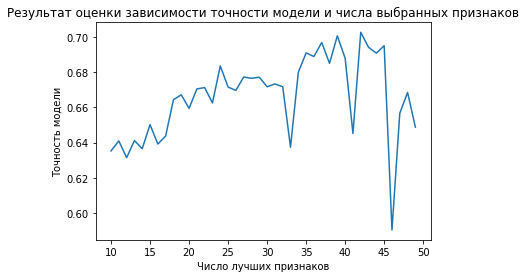

In [46]:
plt.plot(numbers_features, accuracy)
plt.title("Результат оценки зависимости точности модели и числа выбранных признаков")
plt.xlabel('Число лучших признаков')
plt.ylabel("Точность модели")
plt.show()

## Визуализация предсказаний оптимального классификатора

In [50]:
cls = MLPClassifier(max_iter=1000)
features = best_features['feature'].iloc[:best_number].to_numpy()
cls.fit(x_train[:, features], y_train)
train_preds = cls.predict(x_train[:, features])
test_preds = cls.predict(x_test[:, features])

### Оценка предсказаний модели

In [53]:
print(classification_report(train_preds, y_train))
print(classification_report(test_preds, y_test))

              precision    recall  f1-score   support

           0       0.45      0.78      0.57       990
           4       0.88      0.70      0.78      8320
           5       0.50      0.61      0.55       555
           7       0.55      0.69      0.61      3242

    accuracy                           0.70     13107
   macro avg       0.60      0.70      0.63     13107
weighted avg       0.75      0.70      0.71     13107

              precision    recall  f1-score   support

           0       0.45      0.74      0.56     19883
           4       0.76      0.76      0.76    125797
           5       0.50      0.60      0.55     10926
           7       0.72      0.61      0.66     92431

    accuracy                           0.69    249037
   macro avg       0.61      0.67      0.63    249037
weighted avg       0.71      0.69      0.70    249037



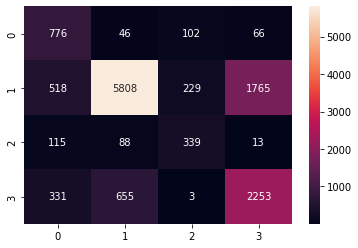

In [54]:
train_conf_mat = confusion_matrix(train_preds, y_train)
sns.heatmap(train_conf_mat, annot=True, fmt="d")

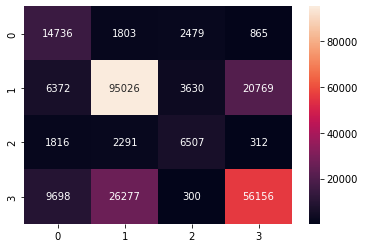

In [55]:
test_conf_mat = confusion_matrix(test_preds, y_test)
sns.heatmap(test_conf_mat, annot=True, fmt="d")

### Построение визуализации предсказаний модели

In [56]:
predictions_map = np.zeros_like(mask)

In [57]:
for (y, x), pred in zip(train_indices, train_preds):
    predictions_map[y, x] = pred
    
for (y, x), pred in zip(test_indices, test_preds):
    predictions_map[y, x] = pred

Text(0.5, 1.0, 'Predictions')

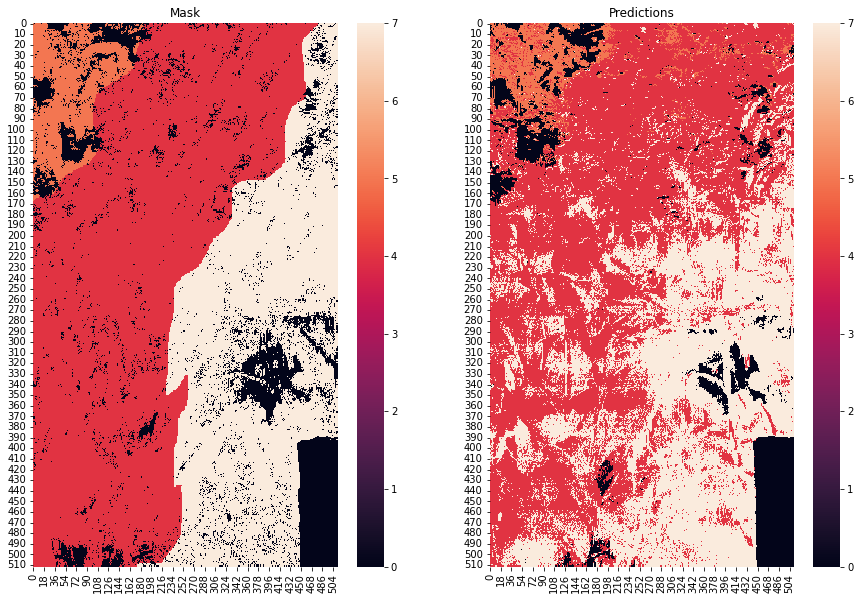

In [58]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 10))
sns.heatmap(mask, ax=ax1)
sns.heatmap(predictions_map, ax=ax2)
ax1.set_title('Mask')
ax2.set_title('Predictions')